# Locate one hammer shot by grid searching over precomputed P arrival times


In [29]:
# Import modules


from pandas import read_csv, to_datetime, DataFrame
from os.path import join
from numpy import load, linspace

from utils_basic import ROOTDIR_GEO, get_geophone_locs
from utils_snuffler import read_phase_markers
from utils_loc import locate_event_3dgrid, plot_rms
from utils_plot import save_figure

In [30]:
# Input parameters
subarray = "A"
hammer = "hammer07-20-22"
indir = ROOTDIR_GEO


In [31]:
# Read the hammer phase markers
inpath = join(indir, f"ppicks_{hammer}.dat")
pick_df = read_phase_markers(inpath)

In [32]:
# Read the precomputed travel time grids

## Read the grid parameters
dirname = f"1d_traveltimes_{subarray}"
inpath = join(indir, dirname, f"grid_params.csv")
param_df = read_csv(inpath, sep=" ")
min_east = param_df["min_east"][0]
eastmax = param_df["max_east"][0]
min_north = param_df["min_north"][0]
max_north = param_df["max_north"][0]
min_depth = param_df["min_depth"][0]
max_depth = param_df["max_depth"][0]

ttimes_of_stations = {}
for i, row in pick_df.iterrows():
    station = row["station"]
    inpath = join(indir, dirname, f"ptimes_{station}.npy")
    
    try:
        ttimes = load(inpath)
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("The pick is removed.")
        pick_df.drop(pick_df[pick_df['station'] == station].index, inplace=True)
        pick_df = pick_df.reset_index(drop=True)
    
    ttimes_of_stations[station] = ttimes

num_depth = ttimes_of_stations[pick_df["station"][0]].shape[0]
num_north = ttimes_of_stations[pick_df["station"][0]].shape[1]
num_east = ttimes_of_stations[pick_df["station"][0]].shape[2]

east_grid = linspace(min_east, eastmax, num_east)
north_grid = linspace(min_north, max_north, num_north)
depth_grid = linspace(min_depth, max_depth, num_depth)


Error: [Errno 2] No such file or directory: '/Volumes/OmanData/data/geophones/1d_traveltimes_A/ptimes_A19.npy'
The pick is removed.


In [33]:
## Read the station information
sta_df = get_geophone_locs()

In [34]:
## Locate the event
ievdp, ievno, ievea, evori, rmsvol, atimedict = locate_event_3dgrid(pick_df, ttimes_of_stations, depth_grid, north_grid, east_grid)

evdepth = depth_grid[ievdp]
evnorth = north_grid[ievno]
eveast = east_grid[ievea]
rmsmin = rmsvol[ievdp, ievno, ievea]

print(f"Hammer shot location: depth = {evdepth:.1f} m, north = {evnorth:.1f} m, east = {eveast:.1f} m")
print(f"RMS = {rmsmin:.3f} s")

Time elapsed: 145.745256 s.
Hammer shot location: depth = 35.0 m, north = -42.0 m, east = 59.0 m
RMS = 0.001 s


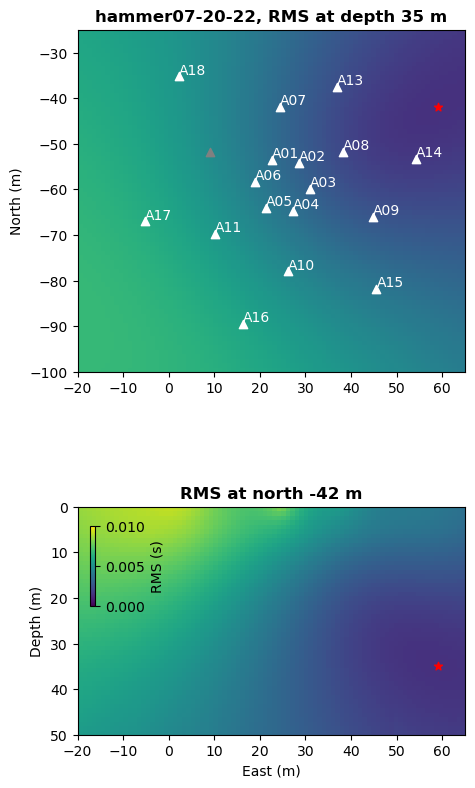

In [35]:
## Plot the RMS map
fig, ax1, ax2, ax3 = plot_rms(rmsvol, ievdp, ievno, ievea, depth_grid, north_grid, east_grid, sta_df, pick_df, hammer, rmsmax=0.01)

In [36]:
## Save the figure
figname = f"rms_maps_{hammer}.png"
save_figure(fig, figname)

Figure saved to /Volumes/OmanData/data/rms_maps_hammer07-20-22.png


In [37]:
## Save the results
outdir = indir
outpath = join(outdir, f"location_{hammer}_.csv")
locdf = DataFrame({"depth": [evdepth], "north": [evnorth], "east": [eveast], "rms": [rmsmin], "origin_time": [evori.strftime("%Y-%m-%dT%H:%M:%S.%f")]})


locdf["depth"] = locdf["depth"].apply(lambda x: f"{x:.1f}")
locdf["north"] = locdf["north"].apply(lambda x: f"{x:.1f}")
locdf["east"] = locdf["east"].apply(lambda x: f"{x:.1f}")
locdf["rms"] = locdf["rms"].apply(lambda x: f"{x:.3f}")

locdf.to_csv(outpath, sep=" ")